<a href="https://colab.research.google.com/github/dmamur/elembert/blob/noPosEmbeddings/elembert_classification_matbench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle,random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,Dense,Dropout,Input,Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import re, glob,os,sys
from collections import defaultdict
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

def bert_module(query, key, value, i, config):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = tf.keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

def create_elembert_model(inputs,config):
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputs)
    encoder_output = word_embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i, config)
    mlm_model = Model(inputs, encoder_output, name="masked_bert_model")

    return mlm_model


In [2]:
!git clone https://github.com/dmamur/elementsem.git

Cloning into 'elementsem'...
remote: Enumerating objects: 1496, done.
remote: Counting objects: 100% (578/578), done.
remote: Compressing objects: 100% (378/378), done.
remote: Total 1496 (delta 364), reused 340 (delta 195), pack-reused 918 (from 1)
Receiving objects: 100% (1496/1496), 120.85 MiB | 9.79 MiB/s, done.
Resolving deltas: 100% (823/823), done.
Updating files: 100% (292/292), done.


In [3]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 128
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 32
    NUM_HEAD = 2 # used in bert model
    FF_DIM = 32 # used in bert model
    NUM_LAYERS = 2
    MNAME = 'elembertR_'
    MVER = 'V0'
    DSPATH="/content/elementsem/data/"
    PREPATH="/content/elementsem/models/pretrained/"
    PATH="/content/elementsem/models/"
config = Config()
seed=12345
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
ds = 'matbench'
mname=config.PATH+config.MNAME+ds+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS)

# Load vocabulary and types

In [5]:
df = pd.read_csv(config.DSPATH+ds+config.MVER+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))
uniquelbls=len(np.unique(np.asarray(df['labels'])))

with open(config.PREPATH+'/el2id'+config.MVER+'.pkl', 'rb') as f:
    db = pickle.load(f)

element2id = db['el2id']
el2id = db['el2id']
config.VOCAB_SIZE = len(element2id)
print('vocabSize: ', config.VOCAB_SIZE)


vocabSize:  101


In [6]:
len(types)

106113

# Convert types to integers

In [9]:
types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#z = load_model(config.PREPATH+'/embert'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z = load_model(config.PREPATH+'/elEmBERT'+'_%s_E_%s_H_%s_L_%s_bert.h5' % (config.MVER,config.EMBED_DIM,config.NUM_HEAD,config.NUM_LAYERS),compile=False)
#z.trainable = True

inputC = Input((config.MAX_LEN,), dtype=tf.int32,name='types')
z = create_elembert_model(inputC,config)

e = Lambda(lambda x: x[:,0],name='clsTokenEmb')(z.output)
f = Dense(uniquelbls, activation="softmax",name='out_tox')(e)

model = Model(inputs=z.input, outputs=f)

#plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

optimizer = tf.keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

epochs=config.BATCH_SIZE
model.summary()

csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".keras",verbose=2, mode='min',save_freq=1000,)

callbacks_list = [checkpoint,csv_logger]

print('dataLen: ',x3.shape,labels.shape)



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ types (InputLayer)        │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ element_embdgs            │ (None, 128, 32)        │          3,232 │ types[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 128)            │              0 │ types[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_multiheadatten… │ (None, 128, 32)        │          4,224 │ element_embdgs[0][0],  │
│ (MultiHeadAttention)      │                        │                │ element_embdgs[0][0],  │
│                           │                        │                │ element_embdgs[0][0],  │
│                           │                        │                │ not_equal_2[0][0],     │
│                           │                        │                │ not_equal_2[0][0],     │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_dropout     │ (None, 128, 32)        │              0 │ encoder_0_multiheadat… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 128, 32)        │              0 │ element_embdgs[0][0],  │
│                           │                        │                │ encoder_0_att_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_att_layernorma… │ (None, 128, 32)        │             64 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn             │ (None, 128, 32)        │          2,112 │ encoder_0_att_layerno… │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_dropout     │ (None, 128, 32)        │              0 │ encoder_0_ffn[0][0]    │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 128, 32)        │              0 │ encoder_0_att_layerno… │
│                           │                        │                │ encoder_0_ffn_dropout… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_0_ffn_layernorma… │ (None, 128, 32)        │             64 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_1_multiheadatten… │ (None, 128, 32)        │          4,224 │ encoder_0_ffn_layerno… │
│ (MultiHeadAttention)      │                        │                │ encoder_0_ffn_layerno… │
│                           │                        │                │ encoder_0_ffn_layerno… │
├──────────────────────

 Total params: 16,226 (63.38 KB)

 Trainable params: 16,226 (63.38 KB)

 Non-trainable params: 0 (0.00 B)

dataLen:  (106113, 128) (106113, 2)


In [10]:
p = np.random.RandomState(seed=seed).permutation(len(labels))
n = len(p)

trainidx=p[:int(len(p)*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

trainlog = model.fit(x=x3[trainidx], y=labels[trainidx],
                     validation_data = (x3[validx],labels[validx]),
                     verbose = 1,epochs = epochs, batch_size = config.BATCH_SIZE,callbacks = callbacks_list)

model.save(mname+".h5")

Epoch 1/128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


664/664 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - auc_2: 0.8997 - loss: 0.3960 - val_auc_2: 0.9320 - val_loss: 0.3336
Epoch 2/128
332/664 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc_2: 0.9298 - loss: 0.3374
Epoch 2: saving model to /content/elementsem/models/elembertR_matbench_V0_E_32_H_2_L_2_bert.h5.keras
664/664 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - auc_2: 0.9302 - loss: 0.3365 - val_auc_2: 0.9354 - val_loss: 0.3246
Epoch 3/128
664/664 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - auc_2: 0.9337 - loss: 0.3281 - val_auc_2: 0.9375 - val_loss: 0.3194
Epoch 4/128
  6/664 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - auc_2: 0.9263 - loss: 0.3424 
Epoch 4: saving model to /content/elementsem/models/elembertR_matbench_V0_E_32_H_2_L_2_bert.h5.keras
664/664 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - auc_2: 0.9354 - loss: 0.3237 - val_auc_2: 0.9383 - val_loss: 0.3178
Epoch 5/128
342/664 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - auc_2: 0.9370 - loss: 0.3197
Epoch 5: saving model to /content/elementsem/models/elembertR_matbench_V0_E_32_H_2_L

# Save results

In [11]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

preds = model.predict(x3,batch_size = config.BATCH_SIZE)

dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = trainidx
dbresults['testidx'] = validx
dbresults['validx'] = validx

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)

830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
830/830 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


# Evaluation on the test set

In [12]:
extractorEmb = Model(inputs=model.inputs,outputs=model.get_layer(name="clsTokenEmb").output)

In [13]:
df = pd.read_csv(config.DSPATH+ds+'_ds.csv')

types = df['types'+config.MVER].apply(eval).apply(list)
labels  = to_categorical(np.asarray(df['labels']))

types0=[['[CLS]']+i+['[SEP]'] for i in types]
typesNumerical=[]
for i in types0:
    typesNumerical.append([element2id[j] for j in i])

x3test = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',truncating='post',maxlen=config.MAX_LEN)

#model =load_model(mname+'.h5')

preds = model.predict(x3test,batch_size = config.BATCH_SIZE)

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [14]:
dbresults={}
dbresults['pred_emb'] = extractorEmb.predict(x3test,batch_size = config.BATCH_SIZE)
dbresults['pred_cls'] = preds
dbresults['y_cls'] = labels
dbresults['formula'] = df['formula']
dbresults['ids'] = df['ids']
dbresults['types'] = types
dbresults['trainidx'] = np.arange(len(labels))
dbresults['testidx'] = np.arange(len(labels))
dbresults['validx'] = np.arange(len(labels))

with open(mname+'_test_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


# Postprocessing

In [15]:
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(dbresults['pred_emb'])

In [16]:
dfr = pd.DataFrame()
dfr["y"] = np.asarray(dbresults['y_cls'].argmax(axis=-1))
dfr["yp"] = np.asarray(dbresults['pred_cls'].argmax(axis=-1))
dfr["tSNE1"] = z[:,0]
dfr["tSNE2"] = z[:,1]

binary tf-acc: [1. 1. 1. ... 1. 1. 1.]
/content/elementsem/models/elembertR_matbench_V0_E_32_H_2_L_2_bert.h5  AUC: 0.96480525


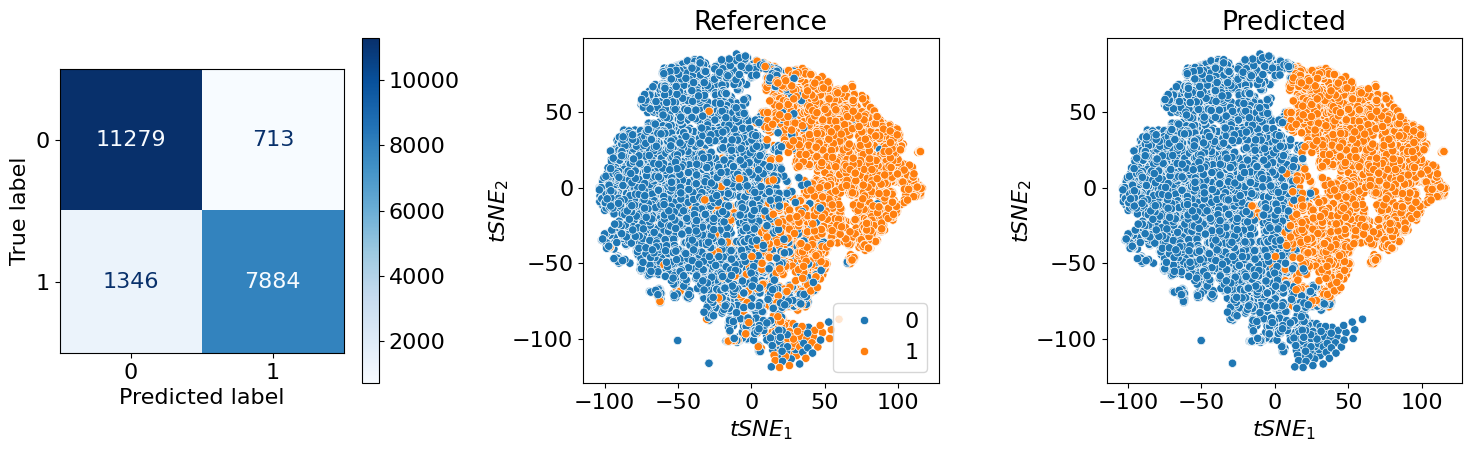

<Figure size 640x480 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(15, 4.8))
y_pclasses = dbresults['pred_cls'].argmax(axis=-1)
y_classes = dbresults['y_cls'].argmax(axis=-1)
print('binary tf-acc:',tf.keras.metrics.binary_accuracy(y_classes, y_pclasses, threshold=0.5).numpy())
m = tf.keras.metrics.AUC()
m.update_state(dbresults['y_cls'], dbresults['pred_cls'])
print(mname, ' AUC:',m.result().numpy())
confusion_matrix = metrics.confusion_matrix(y_classes, y_pclasses)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
                                            #display_labels=['False','True'])
cm_display.plot(ax=axes[0],cmap=plt.cm.Blues)

sns.scatterplot(ax=axes[1],x="tSNE1", y="tSNE2", hue=dfr.y.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[1].set_xlabel('$tSNE_1$')
axes[1].set_ylabel('$tSNE_2$',labelpad=1)
axes[1].set_title('Reference')
#axes[1].legend('',frameon=False)
sns.scatterplot(ax=axes[2],x="tSNE1", y="tSNE2", hue=dfr.yp.tolist(),data=dfr)#.set(title=title+" data T-SNE projection")
axes[2].set_title('Predicted')
axes[2].set_xlabel('$tSNE_1$')
axes[2].set_ylabel('$tSNE_2$',labelpad=1)
axes[2].legend('',frameon=False)
fig.tight_layout()
plt.show()
plt.savefig(mname+'_tsnePaper.jpg',format='jpg',dpi=800,bbox_inches = "tight")